# Cuffless Blood Pressure Feature Extraction

## Data Set Information:

The main goal of this data set is providing clean and valid signals for designing cuff-less blood pressure estimation algorithms. The raw electrocardiogram (ECG), photoplethysmograph (PPG), and arterial blood pressure (ABP) signals are originally collected from the physionet.org and then some preprocessing and validation performed on them.

In [1]:
import pandas as pd
import numpy as np
from scipy.fft import fft
from scipy.signal import find_peaks, argrelextrema, correlate
from scipy.io import loadmat
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
%%time

DATASETS = 12

sample_file = {}

for i in range(1, DATASETS + 1):
    sample_file["{}".format(i)] = loadmat('dataset/archive/part_{}.mat'.format(i))['p'][0]
sample_file

CPU times: total: 33.7 s
Wall time: 34.4 s


{'1': array([array([[ 1.75953079e+00,  1.71847507e+00,  1.68426197e+00, ...,
                 1.64418377e+00,  1.60019550e+00,  1.56598240e+00],
               [ 6.70629552e+01,  6.93586281e+01,  7.53664529e+01, ...,
                 7.64410232e+01,  8.18138747e+01,  9.13873191e+01],
               [-6.06060606e-02, -7.52688172e-02, -7.03812317e-02, ...,
                -1.00195503e-01, -9.04203324e-02, -4.54545455e-02]])   ,
        array([[ 2.40957967,  2.32942326,  2.23851417, ...,  1.24046921,
                 1.23069404,  1.21994135],
               [73.75459745, 73.1684682 , 72.53349484, ..., 99.15353167,
                96.22288542, 93.19455095],
               [ 0.18475073,  0.17986315,  0.16959922, ...,  0.29472141,
                 0.31964809,  0.33968719]])                             ,
        array([[  1.21212121,   1.20136852,   1.19354839, ...,   1.34506354,
                  1.33040078,   1.31671554],
               [ 94.80640639,  91.87576014,  88.55436105, ..., 127.38

In [3]:
sample_file["1"].shape

(1000,)

In [4]:
sample_file["1"][0].shape

(3, 61000)

## Attribute Information:

This database consists of a cell array of matrices, each cell is one record part.
In each matrix each row corresponds to one signal channel:

1: PPG signal, FS=125Hz; photoplethysmograph from fingertip

2: ABP signal, FS=125Hz; invasive arterial blood pressure (mmHg)

3: ECG signal, FS=125Hz; electrocardiogram from channel II

In [5]:
SAMPLING_FREQUENCY = 125
EPSILON = 1e-9

**Sampling Frequency**: Sampling rate or sampling frequency defines the number of samples per second (or per other unit) taken from a continuous signal to make a discrete or digital signal.

### Feature Extraction and Analysis

In [6]:
%%time

ppg_signals = {}
abp_signals = {}
ecg_signals = {}

cnt = 1

for i in range(1, DATASETS + 1):
    for j in range(sample_file[str(i)].shape[0]):

        rec_matrix = sample_file[str(i)][j]
        ppg_signals["patient_{}".format(cnt)] = np.squeeze(rec_matrix[0])
        abp_signals["patient_{}".format(cnt)] = np.squeeze(rec_matrix[1])
        ecg_signals["patient_{}".format(cnt)] = np.squeeze(rec_matrix[2])
        
        cnt += 1
        
ppg_signals

CPU times: total: 0 ns
Wall time: 79.1 ms


{'patient_1': array([1.75953079, 1.71847507, 1.68426197, ..., 1.64418377, 1.6001955 ,
        1.5659824 ]),
 'patient_2': array([2.40957967, 2.32942326, 2.23851417, ..., 1.24046921, 1.23069404,
        1.21994135]),
 'patient_3': array([1.21212121, 1.20136852, 1.19354839, ..., 1.34506354, 1.33040078,
        1.31671554]),
 'patient_4': array([2.44281525, 2.34506354, 2.24242424, ..., 1.53372434, 1.50244379,
        1.47800587]),
 'patient_5': array([1.16813294, 1.20430108, 1.26783969, ..., 1.37438905, 1.35777126,
        1.34115347]),
 'patient_6': array([1.54252199, 1.52394917, 1.50439883, ..., 1.54056696, 1.75659824,
        2.00293255]),
 'patient_7': array([1.5483871 , 1.52394917, 1.49951124, ..., 1.04105572, 1.02346041,
        1.00488759]),
 'patient_8': array([1.73313783, 1.67057674, 1.60997067, ..., 1.6344086 , 1.6285435 ,
        1.62463343]),
 'patient_9': array([1.21212121, 1.19648094, 1.18084066, ..., 1.5483871 , 1.53176931,
        1.51612903]),
 'patient_10': array([2.6901

### Cleaning the dataset as per the paper

In [7]:
datasetSize = len(ppg_signals)

In [8]:
indices_to_remove = []

for i in range(1, datasetSize + 1):
    
    abp_signal = abp_signals["patient_{}".format(i)]
    min_amp = np.min(abp_signal)
    max_amp = np.max(abp_signal)
    
    if (max_amp > 180 or min_amp < 60):
        indices_to_remove.append(i)

indices_to_remove = np.array(indices_to_remove)

for ind in indices_to_remove:
    ppg_signals.pop("patient_{}".format(ind))
    abp_signals.pop("patient_{}".format(ind))
    ecg_signals.pop("patient_{}".format(ind))

In [9]:
patient_ids = np.array(list(ppg_signals.keys()))
patient_ids

array(['patient_4', 'patient_6', 'patient_7', ..., 'patient_11983',
       'patient_11991', 'patient_11992'], dtype='<U13')

### Signal Visualization for a Patient

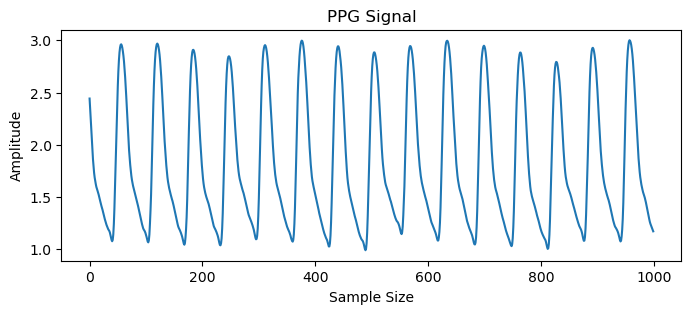

In [10]:
plt.figure(figsize=(8, 3))
plt.title('PPG Signal')
plt.xlabel('Sample Size')
plt.ylabel('Amplitude')
plt.plot(list(ppg_signals.values())[0][:1000])
plt.show()

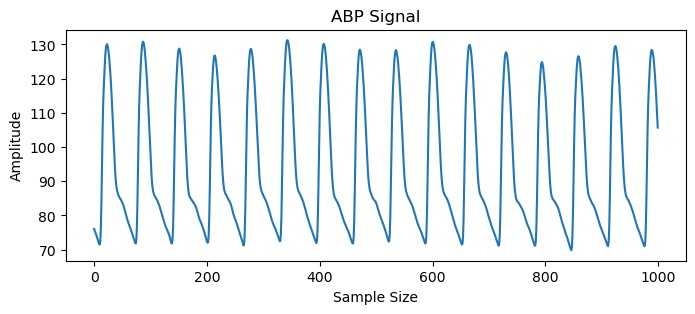

In [11]:
plt.figure(figsize=(8, 3))
plt.title('ABP Signal')
plt.xlabel('Sample Size')
plt.ylabel('Amplitude')
plt.plot(list(abp_signals.values())[0][:1000])
plt.show()

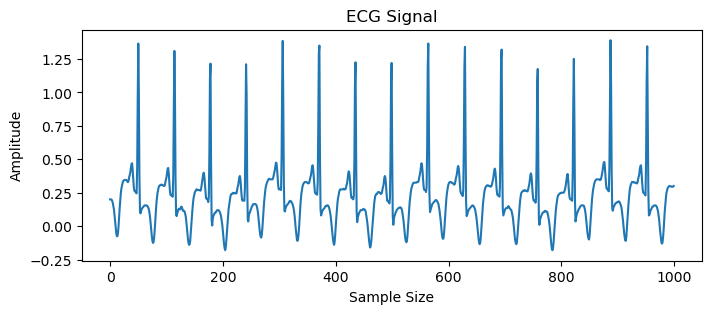

In [12]:
plt.figure(figsize=(8, 3))
plt.title('ECG Signal')
plt.xlabel('Sample Size')
plt.ylabel('Amplitude')
plt.plot(list(ecg_signals.values())[0][:1000])
plt.show()

In [13]:
features = {}

for index in patient_ids:
    features[index] = {}
    
features

{'patient_4': {},
 'patient_6': {},
 'patient_7': {},
 'patient_9': {},
 'patient_10': {},
 'patient_11': {},
 'patient_12': {},
 'patient_13': {},
 'patient_14': {},
 'patient_15': {},
 'patient_17': {},
 'patient_18': {},
 'patient_22': {},
 'patient_24': {},
 'patient_68': {},
 'patient_69': {},
 'patient_70': {},
 'patient_71': {},
 'patient_75': {},
 'patient_76': {},
 'patient_77': {},
 'patient_78': {},
 'patient_79': {},
 'patient_81': {},
 'patient_84': {},
 'patient_98': {},
 'patient_103': {},
 'patient_104': {},
 'patient_105': {},
 'patient_107': {},
 'patient_134': {},
 'patient_135': {},
 'patient_141': {},
 'patient_147': {},
 'patient_148': {},
 'patient_161': {},
 'patient_162': {},
 'patient_165': {},
 'patient_167': {},
 'patient_169': {},
 'patient_170': {},
 'patient_171': {},
 'patient_174': {},
 'patient_175': {},
 'patient_176': {},
 'patient_177': {},
 'patient_243': {},
 'patient_313': {},
 'patient_322': {},
 'patient_323': {},
 'patient_326': {},
 'patient_

### PPG Signal Analysis

Calculating:

1. Photoplethysmogram intensity ratio
2. Maximum amplitude of the pulse signal
3. Minimum amplitude of the pulse signal
4. Viscosity of the blood, calculated as AC amplitude of the pulse signal
5. Systolic width @ 10% of the pulse amplitude
6. Addition of Systolic time and diastolic time @ 10% of the pulse amplitude
7. Division of Diastolic time and systolic time @ 10% of the pulse amplitude.
8. Addition of Systolic time and diastolic time @ 25% of the pulse amplitude
9. Division of Diastolic time and systolic time @ 25% of the pulse amplitude.
10. Addition of Systolic time and diastolic time @ 33% of the pulse amplitude
11. Division of Diastolic time and systolic time @ 33% of the pulse amplitude.
12. Division of Diastolic time and systolic time @ 50% of the pulse amplitude.

In [14]:
%%time

def getDiastolicIntervals(peaks, foot_indices):
    diastolic_time_intervals = []
    for i in range(len(peaks) - 1):
        foot = foot_indices[(foot_indices > peaks[i]) & (foot_indices < peaks[i + 1])]
        if len(foot) > 0:
            diastolic_interval = (foot[0] - peaks[i + 1]) / SAMPLING_FREQUENCY  # Divide by the sampling frequency to get time in seconds
            diastolic_time_intervals.append(diastolic_interval)
            
    diastolic_time_intervals = np.array(diastolic_time_intervals)
    return np.mean(diastolic_time_intervals)

for index in patient_ids:
    patient_sample = ppg_signals[index]
    
    max_amplitude = np.max(patient_sample) # Intensity High
    min_amplitude = np.min(patient_sample) + EPSILON # Intensity Low
    
    ppg_intensity_ratio = max_amplitude / min_amplitude # Photoplethysmogram intensity ratio
    ac_amplitude = max_amplitude - min_amplitude # Viscosity of Blood
    
    pulse_amplitude_10 = 0.1 * ac_amplitude
    pulse_amplitude_25 = 0.2 * ac_amplitude
    pulse_amplitude_33 = 0.33 * ac_amplitude
    pulse_amplitude_50 = 0.5 * ac_amplitude
    
    peaks, _ = find_peaks(patient_sample, height=pulse_amplitude_10)
    systolic_width_10 = np.mean(np.diff(peaks)) / SAMPLING_FREQUENCY # Systolic Width and Time @ 10%
    
    foot_indices = argrelextrema(patient_sample, np.less)[0] # Finding the indices of the minimum wave form of the signal
    diastolic_time_10 = getDiastolicIntervals(peaks, foot_indices) # Diastolic Time @ 10%
    
    peaks, _ = find_peaks(patient_sample, height=pulse_amplitude_25)
    systolic_time_25 = np.mean(np.diff(peaks)) / SAMPLING_FREQUENCY # Systolic Time @ 25%
    
    diastolic_time_25 = getDiastolicIntervals(peaks, foot_indices) # Diastolic Time @ 25%
    
    peaks, _ = find_peaks(patient_sample, height=pulse_amplitude_33)
    systolic_time_33 = np.mean(np.diff(peaks)) / SAMPLING_FREQUENCY # Systolic Time @ 33%
    
    diastolic_time_33 = getDiastolicIntervals(peaks, foot_indices) # Diastolic Time @ 33%
    
    peaks, _ = find_peaks(patient_sample, height=pulse_amplitude_50)
    systolic_time_50 = np.mean(np.diff(peaks)) / SAMPLING_FREQUENCY # Systolic Time @ 50%
    
    diastolic_time_50 = getDiastolicIntervals(peaks, foot_indices) # Diastolic Time @ 50%
    
    features[index]["PIR"] = ppg_intensity_ratio
    features[index]["Ih"] = max_amplitude
    features[index]["Il"] = min_amplitude + EPSILON
    features[index]["Meu0"] = ac_amplitude
    features[index]["Sw10"] = systolic_width_10
    features[index]["St10+Dt10"] = systolic_width_10 + diastolic_time_10
    features[index]["Dt10/St10"] = diastolic_time_10 / systolic_width_10
    features[index]["St25+Dt25"] = systolic_time_25 + diastolic_time_25
    features[index]["Dt25/St25"] = diastolic_time_25 / systolic_time_25
    features[index]["St33+Dt33"] = systolic_time_33 + diastolic_time_33
    features[index]["Dt33/St33"] = diastolic_time_33 / systolic_time_33
    features[index]["Dt50/St50"] = diastolic_time_50 / systolic_time_50

CPU times: total: 36.1 s
Wall time: 36.3 s


In [15]:
features

{'patient_4': {'PIR': 3997067448.6803517,
  'Ih': 3.997067448680352,
  'Il': 2e-09,
  'Meu0': 3.997067447680352,
  'Sw10': 0.48983537653239934,
  'St10+Dt10': 0.36693232944098664,
  'Dt10/St10': -0.25090684131770447,
  'St25+Dt25': 0.36693232944098664,
  'Dt25/St25': -0.25090684131770447,
  'St33+Dt33': 0.36888981384904224,
  'Dt33/St33': -0.2515267670637711,
  'Dt50/St50': -0.2563498324924746},
 'patient_6': {'PIR': 3.966002339909472,
  'Ih': 3.3069403714565007,
  'Il': 0.833822093886608,
  'Meu0': 2.473118278569893,
  'Sw10': 0.5409967637540454,
  'St10+Dt10': 0.4187459162964183,
  'Dt10/St10': -0.22597334336958494,
  'St25+Dt25': 0.4187459162964183,
  'Dt25/St25': -0.22597334336958494,
  'St33+Dt33': 0.4187459162964183,
  'Dt33/St33': -0.22597334336958494,
  'Dt50/St50': -0.22597334336958494},
 'patient_7': {'PIR': 4001955034.2130985,
  'Ih': 4.001955034213099,
  'Il': 2e-09,
  'Meu0': 4.001955033213099,
  'Sw10': 0.5257386468952734,
  'St10+Dt10': 0.40276519556783974,
  'Dt10/St10'

### ABP Signal Analysis

Calculating:
1. Systolic time
2. Diastolic time
3. Augmentation Index
4. Pulse arrival time
5. The frequency of heart rate
6. Womersley number

In [16]:
%%time

from math import sqrt

for index in patient_ids:
    abp_signal = abp_signals[index]
    ecg_signal = ecg_signals[index]
    
    peaks, _ = find_peaks(abp_signal, height=100, distance=SAMPLING_FREQUENCY*0.3)

    # Calculate time differences between successive peaks
    time_diffs = np.diff(peaks) / SAMPLING_FREQUENCY

    # Systolic time is the time difference between successive systolic peaks
    systolic_time = time_diffs[:-1]

    # Diastolic time is the time difference between a diastolic peak and the next systolic peak
    diastolic_time = time_diffs[1:]
    
    # Calculate pulse pressure (systolic - diastolic pressure)
    derivative = np.diff(np.diff(abp_signal))

    # Find the index of the dicrotic notch as the minimum point in the second derivative
    dicrotic_notch_index = np.argmin(derivative)

    # Calculate the systolic pressure (maximum pressure)
    systolic_pressure = np.max(abp_signal)

    # Calculate the diastolic pressure (minimum pressure)
    diastolic_pressure = np.min(abp_signal)

    # Calculate the pulse pressure (systolic - diastolic pressure)
    pulse_pressure = systolic_pressure - diastolic_pressure

    # Calculate the augmented pressure (pressure at the dicrotic notch)
    augmented_pressure = abp_signal[dicrotic_notch_index]

    # Calculate the augmentation index (AIx) as a percentage
    aix = (augmented_pressure - diastolic_pressure) / pulse_pressure * 100 # Augmentation Index
    
    # Normalising ECG and ABP signals
    abp_normalized = (abp_signal - np.mean(abp_signal)) / np.std(abp_signal)
    ecg_normalized = (ecg_signal - np.mean(ecg_signal)) / np.std(ecg_signal)

    # Compute cross-correlation between the normalized ABP and ECG signals
    cross_corr = correlate(abp_normalized, ecg_normalized, mode='full')

    # Find the index of the maximum correlation value
    max_corr_index = np.argmax(cross_corr)

    # Calculate the time delay (Pulse Arrival Time) between ABP and ECG
    pat_abp_ecg = (max_corr_index - len(ecg_signal) + 1) / SAMPLING_FREQUENCY
    
    # Calculating frequency of heart rate
    omega = 1 / np.mean(np.diff(peaks) / SAMPLING_FREQUENCY)
    
    # Womersley Number
    # From the documnet we know the formula to be (alpha = R * sqrt(density * omega / viscosity)
    
    R = features[index]["Il"]
    DENSITY = 1060
    meu = features[index]["Meu0"]
    
    alpha = R * sqrt(DENSITY * omega / meu)
    
    features[index]["St"] = np.mean(systolic_time)
    features[index]["Dt"] = np.mean(diastolic_time)
    features[index]["AI"] = np.mean(aix)
    features[index]["PAT"] = np.mean(pat_abp_ecg)
    features[index]["Omega"] = omega
    features[index]["Alpha0"] = alpha

CPU times: total: 10.8 s
Wall time: 10.9 s


In [17]:
features

{'patient_4': {'PIR': 3997067448.6803517,
  'Ih': 3.997067448680352,
  'Il': 2e-09,
  'Meu0': 3.997067447680352,
  'Sw10': 0.48983537653239934,
  'St10+Dt10': 0.36693232944098664,
  'Dt10/St10': -0.25090684131770447,
  'St25+Dt25': 0.36693232944098664,
  'Dt25/St25': -0.25090684131770447,
  'St33+Dt33': 0.36888981384904224,
  'Dt33/St33': -0.2515267670637711,
  'Dt50/St50': -0.2563498324924746,
  'St': 0.5076185286103543,
  'Dt': 0.5076039963669392,
  'AI': 87.75226165622824,
  'PAT': 0.36,
  'Omega': 1.9700241694435305,
  'Alpha0': 4.571386770508716e-08},
 'patient_6': {'PIR': 3.966002339909472,
  'Ih': 3.3069403714565007,
  'Il': 0.833822093886608,
  'Meu0': 2.473118278569893,
  'Sw10': 0.5409967637540454,
  'St10+Dt10': 0.4187459162964183,
  'Dt10/St10': -0.22597334336958494,
  'St25+Dt25': 0.4187459162964183,
  'Dt25/St25': -0.22597334336958494,
  'St33+Dt33': 0.4187459162964183,
  'Dt33/St33': -0.22597334336958494,
  'Dt50/St50': -0.22597334336958494,
  'St': 0.5516303630363038,
 

### ECG Signal Analysis

Calculating:  
1. The time interval between Q and T of ECG corrected for heart rate.
2. The time interval between two successive R wave of ECG
3. The time interval between Q and T of ECG
4. The time interval between T and Q of successive ECG
5. From the start of the P wave to the start of the QRS complex
6. From the start of the Q wave to the start of the QRS complex
7. From the start to the end of the QRS complex
8. Amplitude of P wave and it represents the atrial depolarization
9. Amplitude of Q wave, negative deflection of QRS complex
10. Amplitude of R wave and it represents the ventricular depolarization
11. Amplitude of S wave
12. Amplitude of T wave and it represents the atrial repolarization
13. Systolic Diastolic time interval
14. New systolic diastolic interval
15. Systolic diastolic interval corrected for RR interval
16. Heart rate

In [18]:
!pip install biosppy

In [19]:
from biosppy.signals import ecg

In [20]:
%%time

for index in patient_ids:

    ecg_signal = ecg_signals[index]
        
    out = ecg.ecg(signal=ecg_signal, sampling_rate=SAMPLING_FREQUENCY, show=False)

    r_peaks = out['rpeaks']

    rr_intervals = np.diff(r_peaks) / SAMPLING_FREQUENCY * 1000 # Time interval between two successive R wave of ECG in ms
    
    q_wave_indices = np.array([np.argmin(ecg_signal[r:r + int(0.06 * SAMPLING_FREQUENCY)]) + r for r in r_peaks])
    t_wave_indices = np.array([r + np.argmax(ecg_signal[r:r + int(0.4 * SAMPLING_FREQUENCY)]) for r in r_peaks])
    qt_intervals = (t_wave_indices - q_wave_indices) / SAMPLING_FREQUENCY # QT Intervals
    tq_intervals = (q_wave_indices[1:] - t_wave_indices[:-1]) / SAMPLING_FREQUENCY # TQ Intervals for Successive ECG
    q_qrs_intervals = (r_peaks - q_wave_indices) / SAMPLING_FREQUENCY # Q wave to the start of the QRS complex

    p_wave_indices = []
    for r_peak_index in r_peaks:
        
        window_start = max(0, r_peak_index - int(0.1 * SAMPLING_FREQUENCY))
        window_end = r_peak_index

        p_wave_index = window_start + np.argmin(ecg_signal[window_start:window_end])
        p_wave_indices.append(p_wave_index)
        
    p_wave_indices = np.array(p_wave_indices)

    pw_rw_intervals = []
    
    for p_index, r_index in zip(p_wave_indices, r_peaks):
        time_interval = (r_index - p_index) / SAMPLING_FREQUENCY
        pw_rw_intervals.append(time_interval)
    pw_rw_intervals = np.array(pw_rw_intervals) # Time interval between P and QRS complex
    
    q_wave_indices = []
    for r_peak_index in r_peaks:
        window_start = max(0, r_peak_index - int(0.05 * SAMPLING_FREQUENCY))
        window_end = r_peak_index

        q_wave_index = window_start + np.argmin(ecg_signal[window_start:window_end])
        q_wave_indices.append(q_wave_index)
        
    q_wave_indices = np.array(q_wave_indices)
    
    qr_intervals = []
    for q_index, r_index in zip(q_wave_indices, r_peaks):
        time_interval = (r_index - q_index) / SAMPLING_FREQUENCY
        qr_intervals.append(time_interval)
        
    qr_intervals = np.array(qr_intervals) # Time interval between Q and QRS complex

    features[index]["QTc"] = np.mean(qt_intervals) / sqrt(np.mean(rr_intervals)) # Time interval between Q and T of ECG corrected for heart rate
    features[index]["RR"] = np.mean(rr_intervals) / 1000
    features[index]["QT"] = np.mean(qt_intervals)
    features[index]["TQ"] = np.mean(tq_intervals)
    features[index]["PR"] = np.mean(pw_rw_intervals)
    features[index]["QR"] = np.mean(qr_intervals)
    
    q_wave_indices = []
    s_wave_indices = []
    for r_peak_index in r_peaks:
        window_start = max(0, r_peak_index - int(0.05 * SAMPLING_FREQUENCY))
        window_end = min(len(ecg_signal) - 1, r_peak_index + int(0.05 * SAMPLING_FREQUENCY))

        q_wave_index = window_start + np.argmin(ecg_signal[window_start:r_peak_index])
        q_wave_indices.append(q_wave_index)

        s_wave_index = r_peak_index + np.argmin(ecg_signal[r_peak_index:window_end])
        s_wave_indices.append(s_wave_index)
        
    q_wave_indices = np.array(q_wave_indices)
    s_wave_indices = np.array(s_wave_indices)
    
    qrs_intervals = []
    for q_index, s_index in zip(q_wave_indices, s_wave_indices):
        time_interval = (s_index - q_index) / SAMPLING_FREQUENCY
        qrs_intervals.append(time_interval)
        
    qrs_intervals = np.array(qrs_intervals) # Time interval from the start to the end of QRS complex
    
    p_wave_amplitudes = ecg_signal[p_wave_indices]
    p_wave_amplitude = np.max(p_wave_amplitudes) - np.min(p_wave_amplitudes) # Compute P-wave amplitude

    q_wave_amplitudes = ecg_signal[q_wave_indices]
    q_wave_amplitude = np.max(q_wave_amplitudes) - np.min(q_wave_amplitudes) # Compute Q-wave amplitude

    r_wave_amplitudes = ecg_signal[r_peaks]
    r_wave_amplitude = np.max(r_wave_amplitudes) - np.min(r_wave_amplitudes) # Compute R-wave amplitude

    s_wave_amplitudes = ecg_signal[s_wave_indices]
    s_wave_amplitude = np.max(s_wave_amplitudes) - np.min(s_wave_amplitudes) # Compute S-wave amplitude
    
    t_wave_amplitudes = ecg_signal[t_wave_indices]
    t_wave_amplitude = np.max(t_wave_amplitudes) - np.min(t_wave_amplitudes) # Compute T-wave amplitude
    
    features[index]["QRS"] = np.mean(qrs_intervals)
    features[index]["P"] = np.mean(p_wave_amplitude)
    features[index]["Q"] = np.mean(q_wave_amplitude)
    features[index]["R"] = np.mean(r_wave_amplitude)
    features[index]["S"] = np.mean(s_wave_amplitude)
    features[index]["T"] = np.mean(s_wave_amplitude)
    features[index]["SDI"] = features[index]["QT"] / (features[index]["TQ"] + EPSILON)
    features[index]["SDIn"] = features[index]["QT"] / (features[index]["RR"] + EPSILON)
    features[index]["SDIc"] = features[index]["QTc"] / (features[index]["TQ"] + EPSILON)
    features[index]["HR"] = 60 / np.mean(rr_intervals / 1000)

CPU times: total: 5min 59s
Wall time: 6min


In [21]:
features

{'patient_4': {'PIR': 3997067448.6803517,
  'Ih': 3.997067448680352,
  'Il': 2e-09,
  'Meu0': 3.997067447680352,
  'Sw10': 0.48983537653239934,
  'St10+Dt10': 0.36693232944098664,
  'Dt10/St10': -0.25090684131770447,
  'St25+Dt25': 0.36693232944098664,
  'Dt25/St25': -0.25090684131770447,
  'St33+Dt33': 0.36888981384904224,
  'Dt33/St33': -0.2515267670637711,
  'Dt50/St50': -0.2563498324924746,
  'St': 0.5076185286103543,
  'Dt': 0.5076039963669392,
  'AI': 87.75226165622824,
  'PAT': 0.36,
  'Omega': 1.9700241694435305,
  'Alpha0': 4.571386770508716e-08,
  'QTc': -0.0011828425453725424,
  'RR': 0.510392694063927,
  'QT': -0.026722627737226275,
  'TQ': 0.537110502283105,
  'PR': 0.028664233576642335,
  'QR': 0.028423357664233578,
  'QRS': 0.056620437956204375,
  'P': 0.3704789833822092,
  'Q': 0.239980449657869,
  'R': 0.38025415444770294,
  'S': 0.23020527859237538,
  'T': 0.23020527859237538,
  'SDI': -0.04975256967399328,
  'SDIn': -0.052356994909339864,
  'SDIc': -0.002202233131064

### Exporting the extracted features to CSV

In [22]:
dataFrame = pd.DataFrame(features).T
dataFrame.head()
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2964 entries, patient_4 to patient_11992
Data columns (total 34 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PIR        2964 non-null   float64
 1   Ih         2964 non-null   float64
 2   Il         2964 non-null   float64
 3   Meu0       2964 non-null   float64
 4   Sw10       2964 non-null   float64
 5   St10+Dt10  2963 non-null   float64
 6   Dt10/St10  2963 non-null   float64
 7   St25+Dt25  2963 non-null   float64
 8   Dt25/St25  2963 non-null   float64
 9   St33+Dt33  2963 non-null   float64
 10  Dt33/St33  2963 non-null   float64
 11  Dt50/St50  2963 non-null   float64
 12  St         2896 non-null   float64
 13  Dt         2896 non-null   float64
 14  AI         2964 non-null   float64
 15  PAT        2964 non-null   float64
 16  Omega      2902 non-null   float64
 17  Alpha0     2902 non-null   float64
 18  QTc        2964 non-null   float64
 19  RR         2964 non-null   float64
 

In [24]:
dataFrame.to_csv('./features/extracted.csv', index=False)

### Footnotes

Certain features could not be extracted. These include: 
1. Large artery stiffness ratio
2. Inflection point area ratio
3. Viscosity of the blood calculated based on pulse pressure wave propagation
4. Womersley number(2nd method)

This notebook successfully extracted 34 out of 38 features present in the dataset.